In [21]:
import torch
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# 加载特征
feats_list = torch.load(
    "logs/dinov2_backbone_dinov2_large/lightning_logs/version_0/feats_list.pth"
)
feats_num = len(feats_list)
print(feats_num)

print(len(feats_list[0]))

steps = [10, 100, 1000]

all_feats_change = []
for j in range(len(feats_list[0])):  # 遍历每个特征
    feats_change = []
    for step in steps:
        tmp_feats_change = []
        for i in range(0, feats_num - step):
            current_feats = feats_list[i][j]
            next_feats = feats_list[i + step][j]
            # 计算特征变化, 使用欧氏距离
            distance = torch.norm(current_feats - next_feats, p=2)
            tmp_feats_change.append(distance)
        feats_change.append(tmp_feats_change)
    all_feats_change.append(feats_change)

19540
4


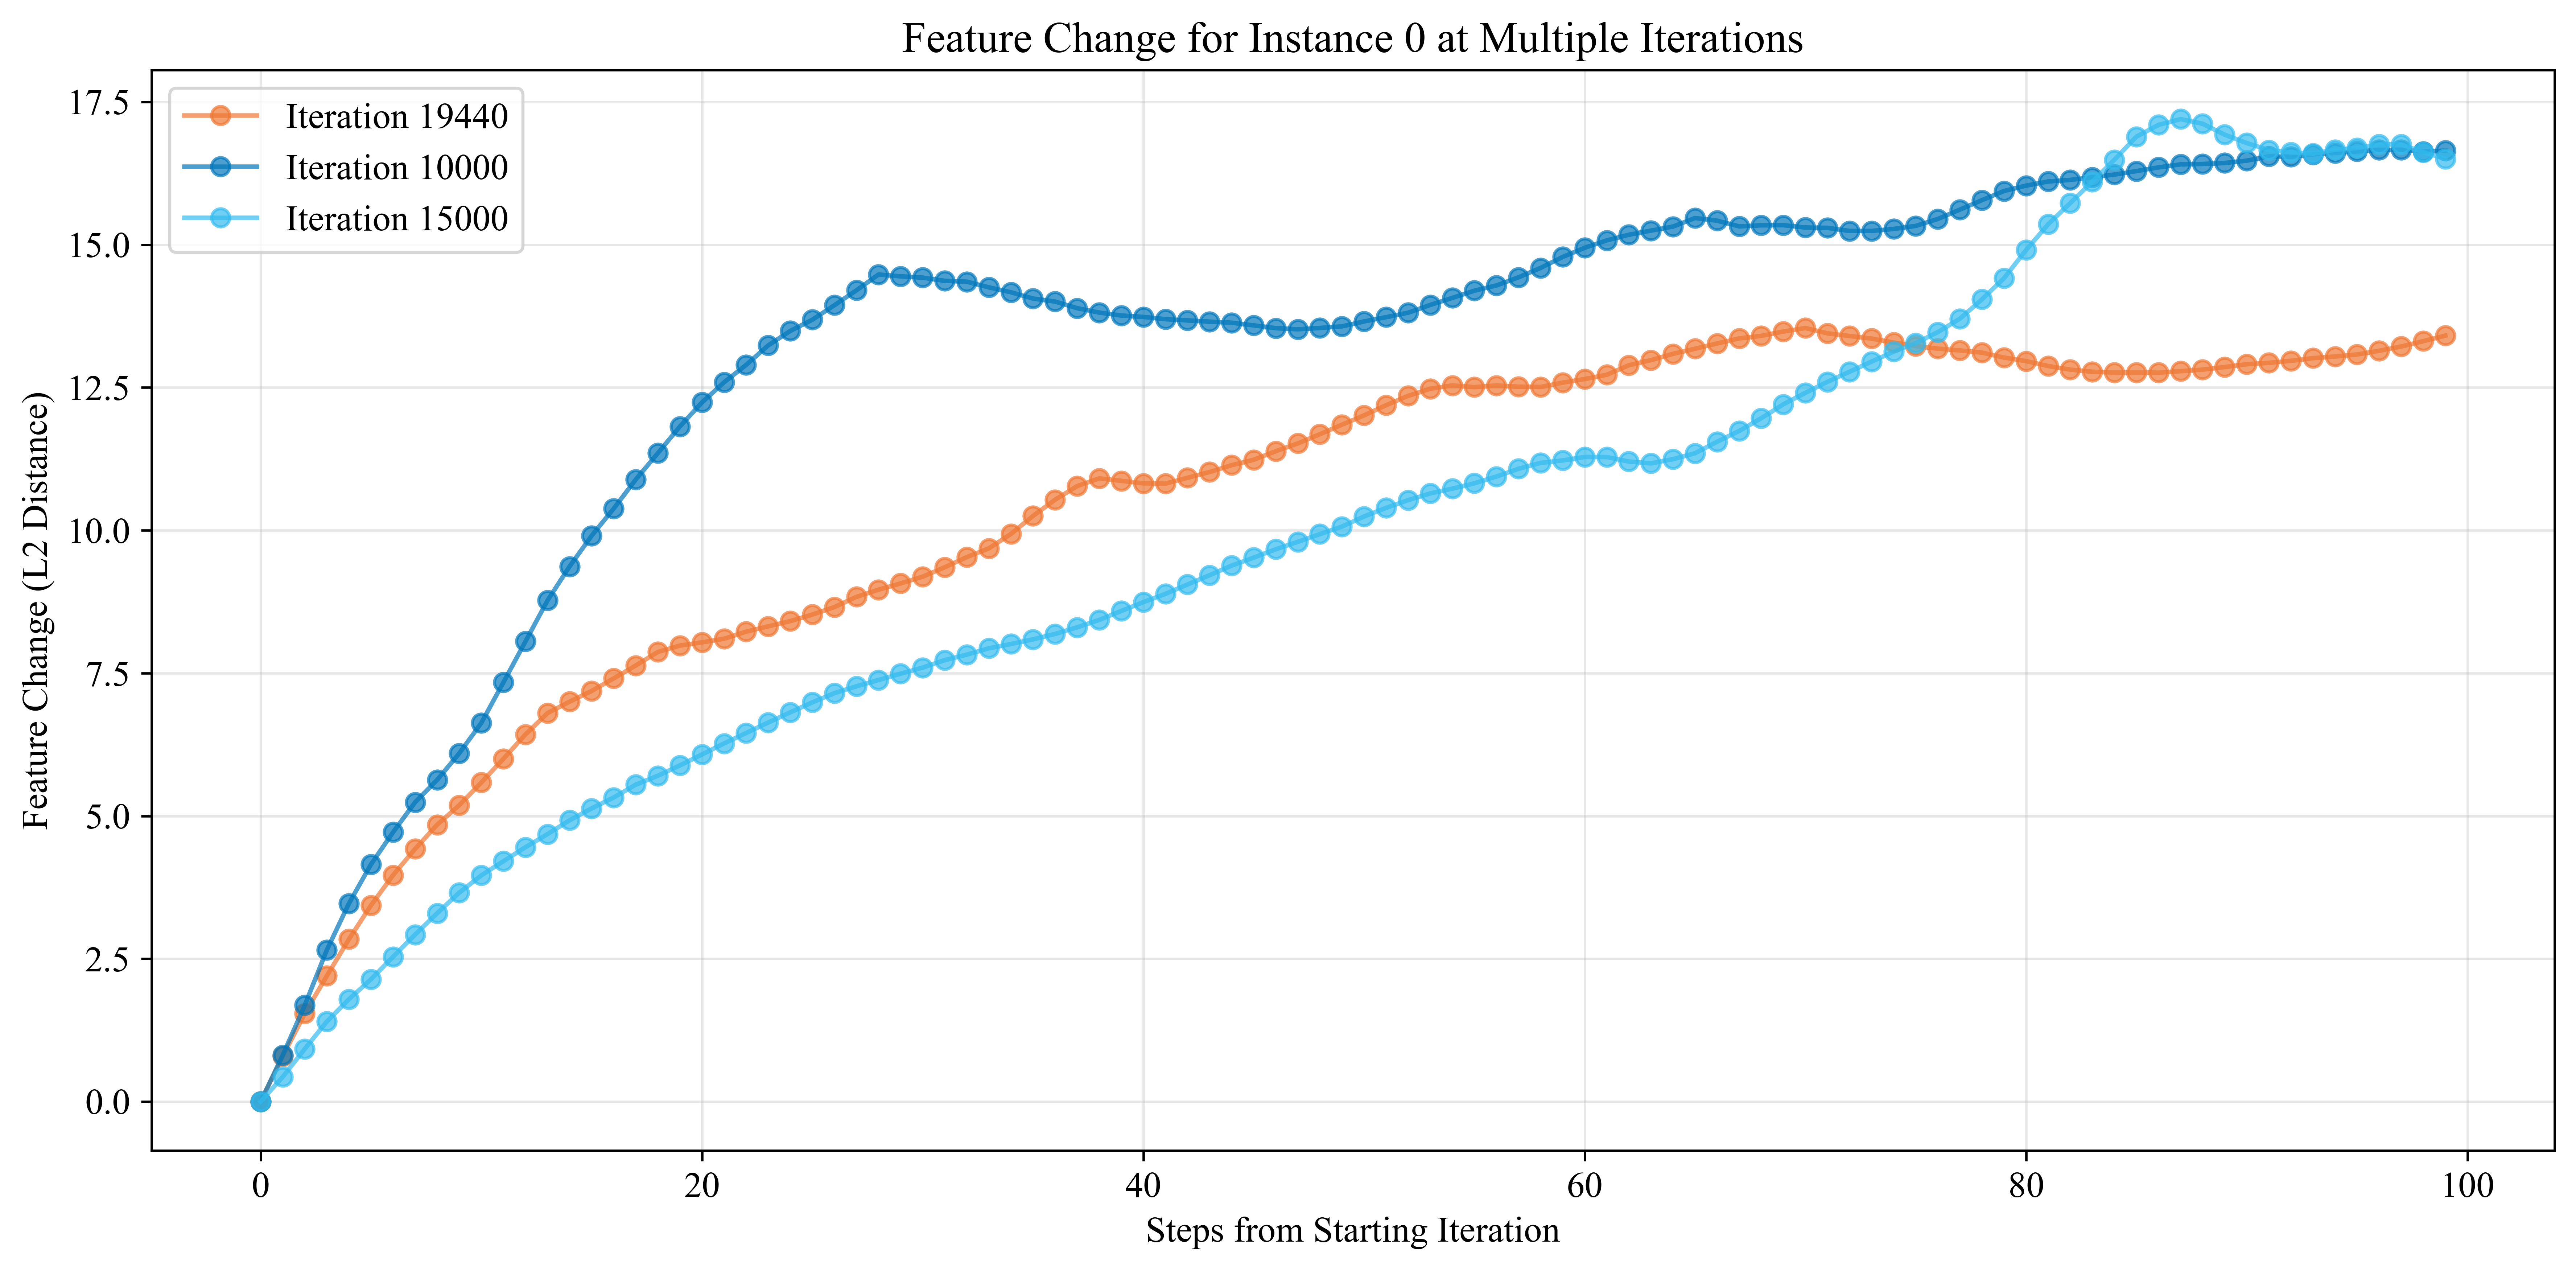


DataFrame Info:
iteration               int64
idx19440_instance0    float64
idx10000_instance0    float64
idx15000_instance0    float64
dtype: object

First few rows:
   iteration  idx19440_instance0  idx10000_instance0  idx15000_instance0
0          0            0.000000            0.000000            0.000000
1          1            0.791363            0.810875            0.431936
2          2            1.540610            1.687233            0.922190
3          3            2.201138            2.653675            1.400284
4          4            2.841639            3.468178            1.791824

Data saved to: tmp_files/instance0_multiple_idx_feature_change.csv
Total columns: 4, Total rows: 100


In [28]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 定义多个要分析的idx
idx_list = [19440, 10000, 15000, 20000]  # 可以根据需要添加更多idx
feats_index = 0  # 分析第0个特征
window_size = 100  # 分析窗口大小

# 创建字典存储所有数据
all_data = {"iteration": list(range(window_size))}

# 创建figure用于可视化
plt.figure(figsize=(12, 6))

# 遍历每个idx
for idx in idx_list:
    # 确保不会超出范围
    if idx + window_size > len(feats_list):
        print(f"Warning: idx {idx} + window_size exceeds feats_list length, skipping...")
        continue
    
    # 选择该idx对应的特征序列
    selected_instance = feats_list[idx:idx + window_size]
    selected_instance = [i[feats_index] for i in selected_instance]
    
    # 获取起始特征
    current_feat = selected_instance[0]
    
    # 计算特征变化
    feat_change = []
    for step in selected_instance:
        distance = torch.norm(current_feat - step, p=2)
        # 转换为Python float，确保是数值而非tensor
        feat_change.append(float(distance.item()))
    
    # 添加到数据字典
    column_name = f"idx{idx}_instance{feats_index}"
    all_data[column_name] = feat_change
    
    # 绘制曲线
    plt.plot(range(len(feat_change)), feat_change, marker='o', label=f'Iteration {idx}', alpha=0.7)

# 设置图表
plt.xlabel('Steps from Starting Iteration')
plt.ylabel('Feature Change (L2 Distance)')
plt.title(f'Feature Change for Instance {feats_index} at Multiple Iterations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存图像
plt.savefig(f'tmp_files/instance{feats_index}_multiple_idx_feature_change.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 保存数据到CSV文件
df = pd.DataFrame(all_data)

# 验证数据类型（确保都是数值）
print("\nDataFrame Info:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

# 保存CSV
csv_filename = f"tmp_files/instance{feats_index}_multiple_idx_feature_change.csv"
df.to_csv(csv_filename, index=False, float_format='%.6f')
print(f"\nData saved to: {csv_filename}")
print(f"Total columns: {len(df.columns)}, Total rows: {len(df)}")

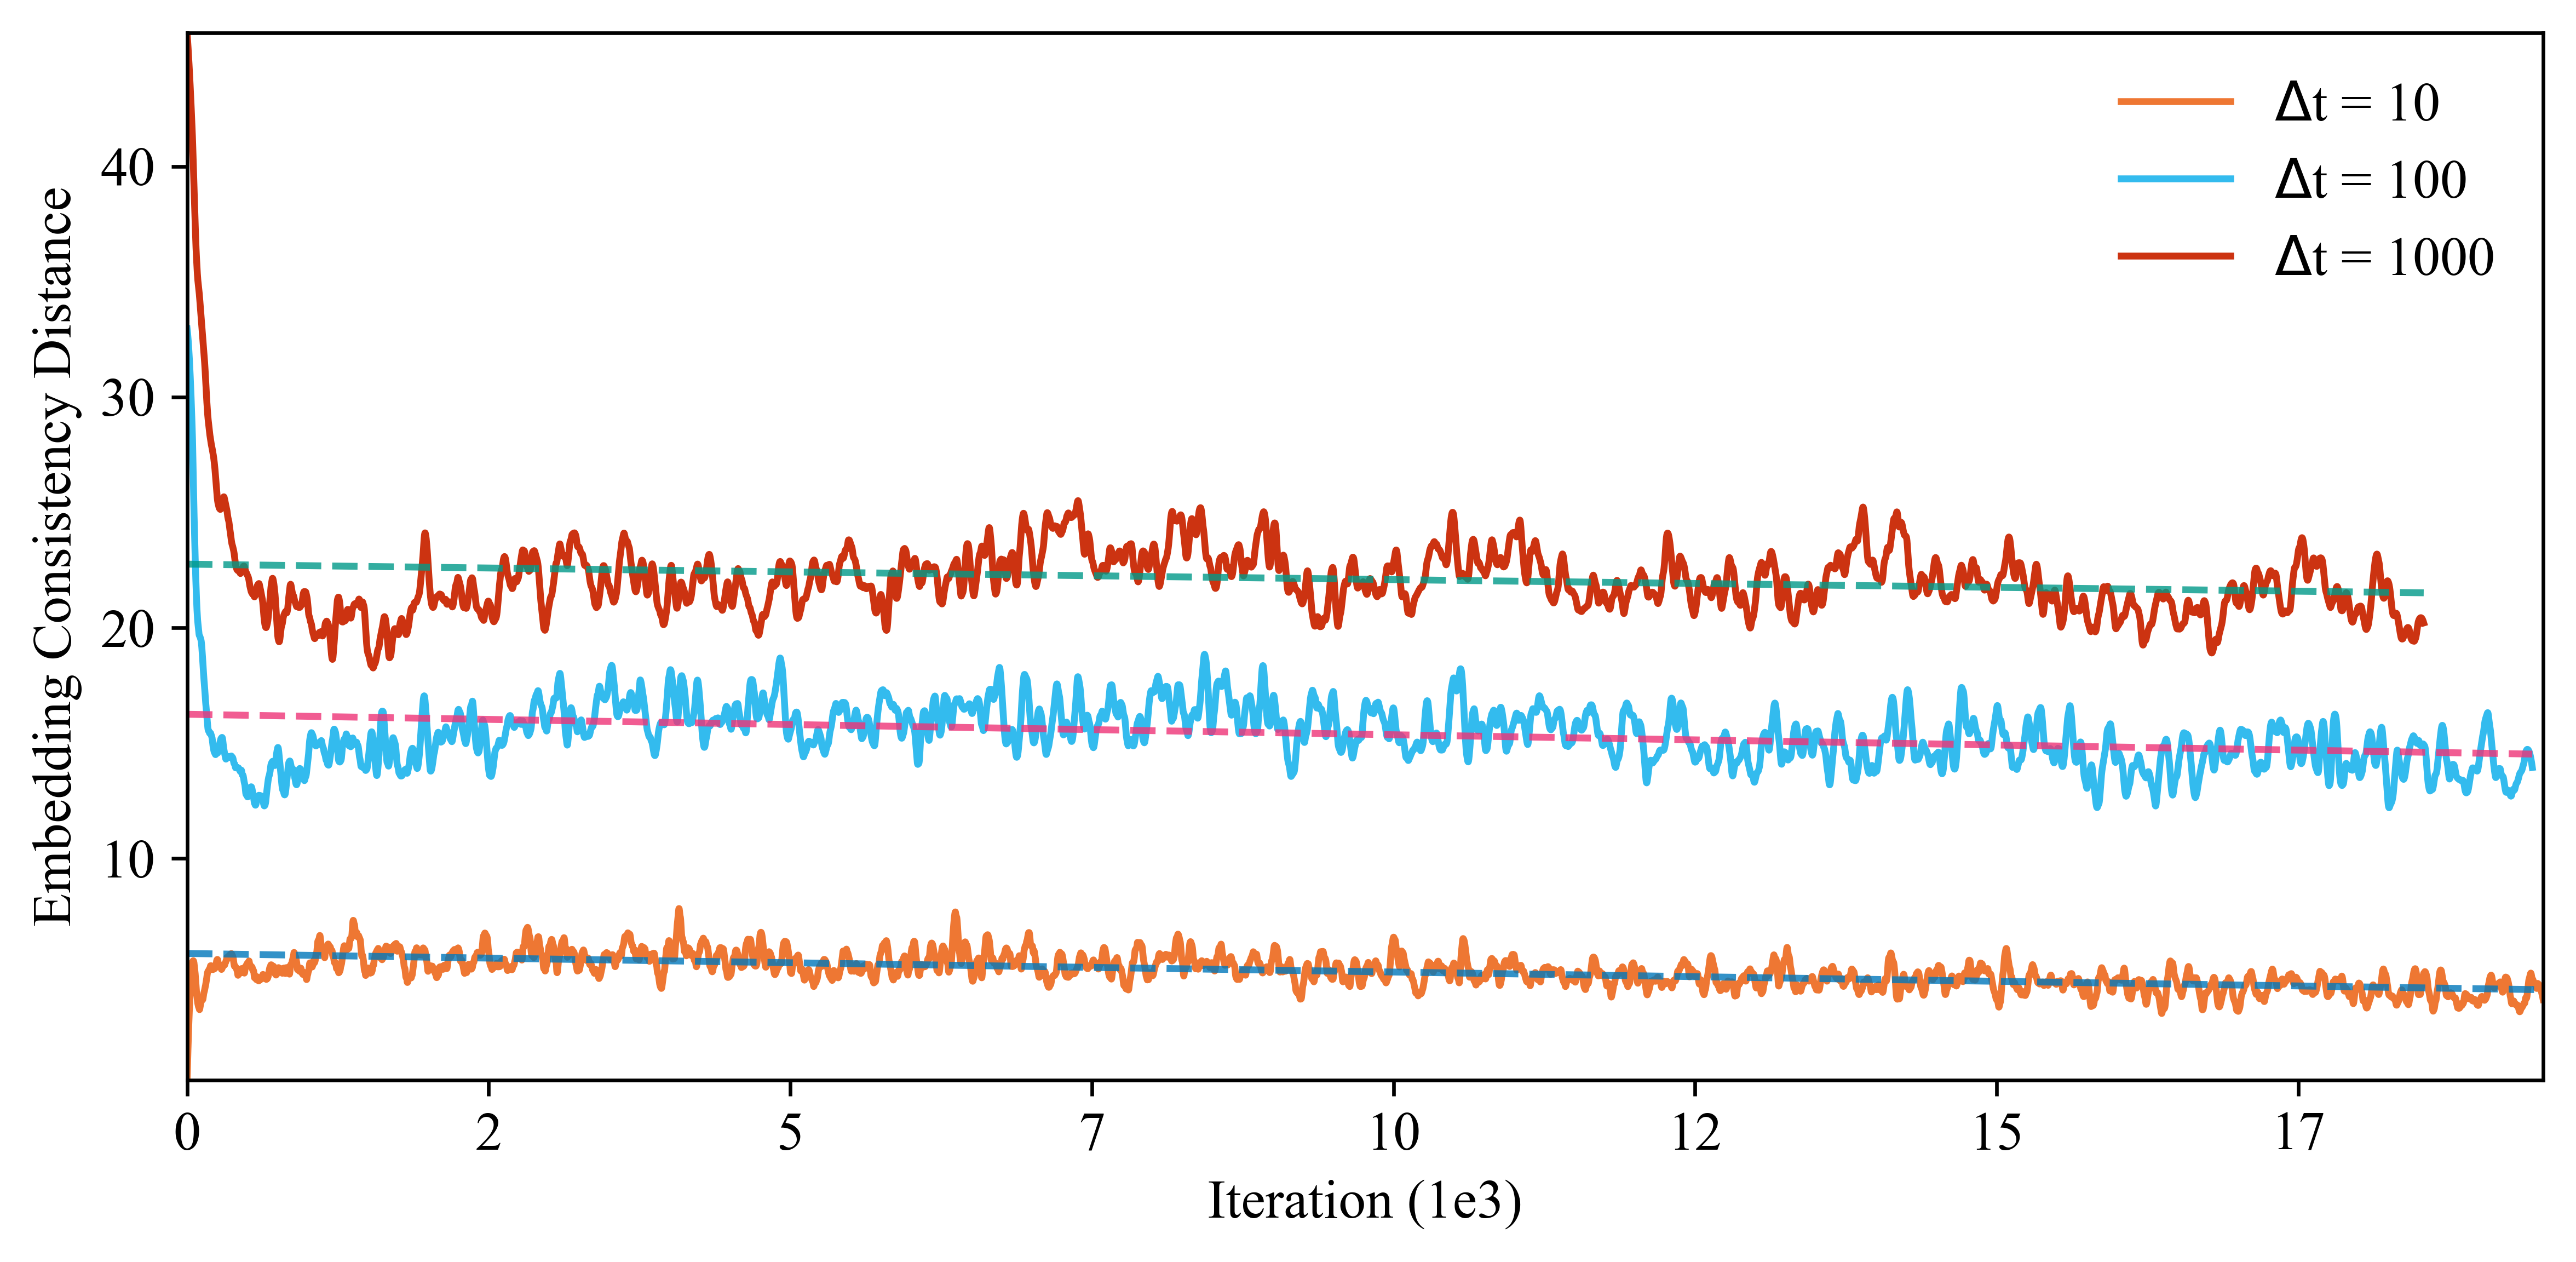

In [ ]:
# 遍历每个特征，将不同step的特征变化绘制在一张图上
# 创建一个figure，将all_feats_change中的四个元素绘制在一张图的子图上，两行两列
import scienceplots
import numpy as np

plt.style.use(["ieee", "vibrant"])
# 设置全局字体和大小
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

# 创建一个字典来存储要保存的数据
# 创建一个DataFrame用于保存数据
import pandas as pd

df_dict = {}

fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # 修改为单个子图

# 只遍历第一个特征
idx = 0
feats_change = all_feats_change[idx]
for i in range(len(feats_change)):
    change = feats_change[i]
    window_length = min(91, len(change) - (1 - len(change) % 2))
    smoothed_change = savgol_filter(change, window_length, 2)

    # 将数据添加到字典中，使用索引作为键
    column_name = f"instance{idx+1}_step{steps[i]}"
    df_dict[column_name] = pd.Series(smoothed_change.tolist())

    # 添加原始曲线
    ax.plot(smoothed_change, label=f"$\Delta$t = {steps[i]}")

    # 计算并添加趋势线，但不添加标签
    x = np.arange(len(smoothed_change))
    z = np.polyfit(x, smoothed_change, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "--", alpha=0.8)

# 设置x轴刻度为千单位
ax.set_xticks(ax.get_xticks())  # 先获取当前刻度
ax.set_xticklabels([f"{int(x/1000)}" for x in ax.get_xticks()])

ax.set_xlabel("Iteration (1e3)")
ax.set_ylabel("Embedding Consistency Distance")
ax.legend(frameon=False)
ax.autoscale(tight=True)

# 将数据保存到CSV文件
import pandas as pd

df = pd.DataFrame(df_dict)
df.to_csv(
    "some_result_images/feats_change/feats_change_data.csv",
    index=True,
    index_label="iteration",
)

plt.tight_layout()
# plt.savefig('some_result_images/feats_change/feats_change_instance_v1.png', bbox_inches='tight', dpi=600)
plt.show()

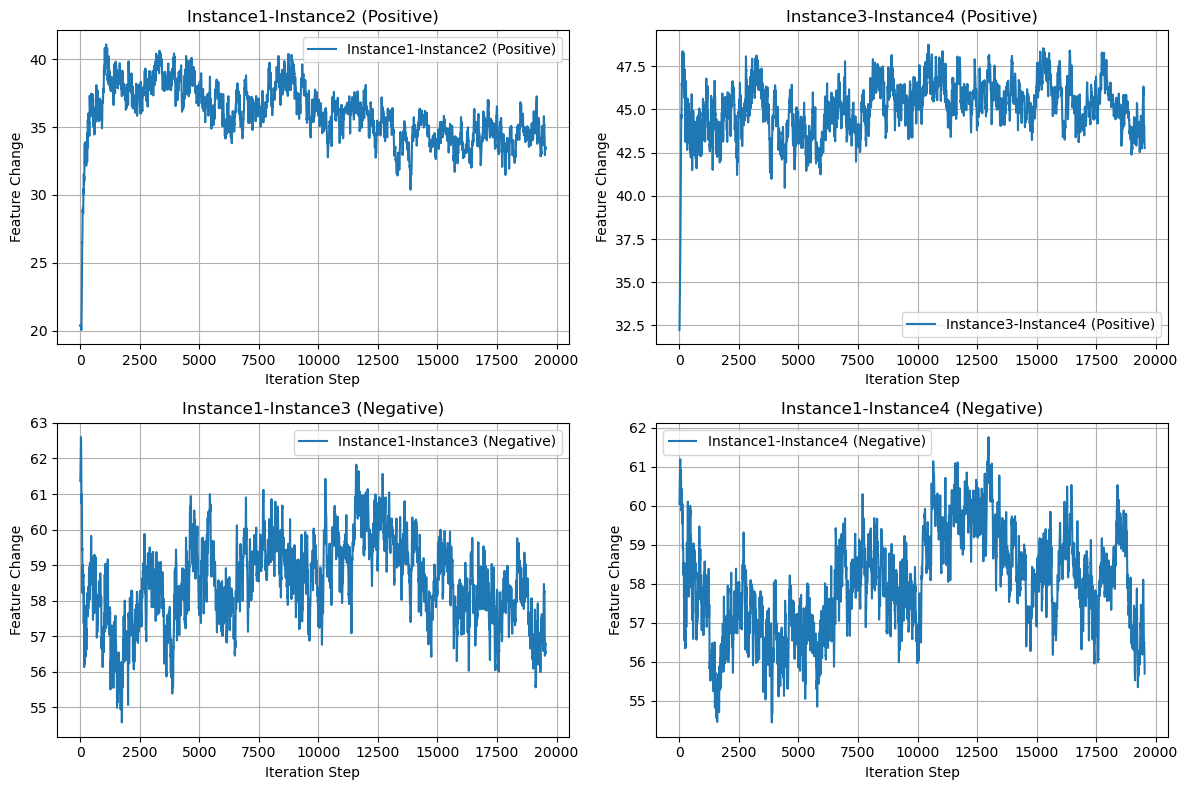

In [ ]:
instance1, instance2, instance3, instance4 = [], [], [], []
for i in range(len(feats_list)):
    instance1.append(feats_list[i][0])
    instance2.append(feats_list[i][1])
    instance3.append(feats_list[i][2])
    instance4.append(feats_list[i][3])

# 计算instance1和instance2的欧氏距离
instance1_instance2_distance = []
for i in range(len(instance1)):
    distance = torch.norm(instance1[i] - instance2[i], p=2)
    instance1_instance2_distance.append(distance)

# 计算instance3和instance4的欧氏距离
instance3_instance4_distance = []
for i in range(len(instance3)):
    distance = torch.norm(instance3[i] - instance4[i], p=2)
    instance3_instance4_distance.append(distance)

# 计算instance1和instance3的欧氏距离
instance1_instance3_distance = []
for i in range(len(instance1)):
    distance = torch.norm(instance1[i] - instance3[i], p=2)
    instance1_instance3_distance.append(distance)

# 计算instance1和instance4的欧氏距离
instance1_instance4_distance = []
for i in range(len(instance1)):
    distance = torch.norm(instance1[i] - instance4[i], p=2)
    instance1_instance4_distance.append(distance)


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(instance1_instance2_distance, label=f"Instance1-Instance2 (Positive)")
axs[0, 0].set_title(f"Instance1-Instance2 (Positive)")
axs[0, 0].set_xlabel("Iteration Step")
axs[0, 0].set_ylabel("Feature Change")
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(instance3_instance4_distance, label=f"Instance3-Instance4 (Positive)")
axs[0, 1].set_title(f"Instance3-Instance4 (Positive)")
axs[0, 1].set_xlabel("Iteration Step")
axs[0, 1].set_ylabel("Feature Change")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(instance1_instance3_distance, label=f"Instance1-Instance3 (Negative)")
axs[1, 0].set_title(f"Instance1-Instance3 (Negative)")
axs[1, 0].set_xlabel("Iteration Step")
axs[1, 0].set_ylabel("Feature Change")
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(instance1_instance4_distance, label=f"Instance1-Instance4 (Negative)")
axs[1, 1].set_title(f"Instance1-Instance4 (Negative)")
axs[1, 1].set_xlabel("Iteration Step")
axs[1, 1].set_ylabel("Feature Change")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()

plt.savefig(
    "some_result_images/feats_change/feats_change_instance_v1.png",
    dpi=600,
    bbox_inches="tight",
)
plt.show()